<a href="https://colab.research.google.com/github/nabeela26/semesterProject/blob/main/ResNet50V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import All NecessaryPackages**

In [1]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.models import load_model
import os
import cv2
import numpy as np
from tensorflow import lite
from keras.preprocessing import image
from PIL import Image
from tensorflow import lite
#from tensorflow.keras.models import load_model

# **Extract the Data from our Kaggle Pakistan Curency DataSet**

In [2]:
# Dataset - https://www.kaggle.com/datasets/khizarjamshaid/pakistan-currency-dataset

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [4]:
#!kaggle datasets download -d salader/dogs-vs-cats
!kaggle datasets download -d khizarjamshaid/pakistan-currency-dataset

Dataset URL: https://www.kaggle.com/datasets/khizarjamshaid/pakistan-currency-dataset
License(s): other
100% 2.78G/2.78G [02:08<00:00, 24.3MB/s]
100% 2.78G/2.78G [02:08<00:00, 23.2MB/s]


In [5]:
import zipfile
zip_ref = zipfile.ZipFile('/content/pakistan-currency-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

# **Connect With the GoogleDrive**

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# **Preprocessing the Data**

In [7]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]


train_path = '/content/Pakistan/Training'
valid_path = '/content/Pakistan/Valid'

# add preprocessing layer to the front of ResNet50V2
resnet = ResNet50V2(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in resnet.layers:
  layer.trainable = False

# useful for getting number of classes
folders = glob('/content/Pakistan/Training/*')
print(folders)

# our layers - you can add more if you want
x = Flatten()(resnet.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=resnet.input, outputs=prediction)

# view the structure of the model
model.summary()

# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


#ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)


training_set = train_datagen.flow_from_directory('/content/Pakistan/Training',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('/content/Pakistan/Valid',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
['/content/Pakistan/Training/10Rsback', '/content/Pakistan/Training/20Rs', '/content/Pakistan/Training/500Rsback', '/content/Pakistan/Training/100Rsback', '/content/Pakistan/Training/5000Rsback', '/content/Pakistan/Training/5000Rs', '/content/Pakistan/Training/100Rs', '/content/Pakistan/Training/others', '/content/Pakistan/Training/1000Rsback', '/content/Pakistan/Training/20Rsback', '/content/Pakistan/Training/1000Rs', '/content/Pakistan/Training/500Rs', '/content/Pakistan/Training/50Rsback', '/content/Pakistan/Training/10Rs', '/content/Pakistan/Training/50Rs']


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 56, 56, 64)     │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 56, 56, 64)     │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 58, 58, 64)     │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_preact_r… │
│ (Conv2D)             

 Total params: 25,070,095 (95.63 MB)

 Trainable params: 1,505,295 (5.74 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

Found 5949 images belonging to 15 classes.
Found 236 images belonging to 15 classes.


# **Run epochs**

In [8]:
# fit the model
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=5,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


186/186 ━━━━━━━━━━━━━━━━━━━━ 247s 1s/step - accuracy: 0.3409 - loss: 9.4991 - val_accuracy: 0.7373 - val_loss: 4.2062
Epoch 2/5
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/5


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


186/186 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.6982 - loss: 3.9918 - val_accuracy: 0.6992 - val_loss: 5.8117
Epoch 4/5
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 143us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/5
186/186 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.7704 - loss: 3.2241 - val_accuracy: 0.7585 - val_loss: 5.8701


# **Loss Graph**

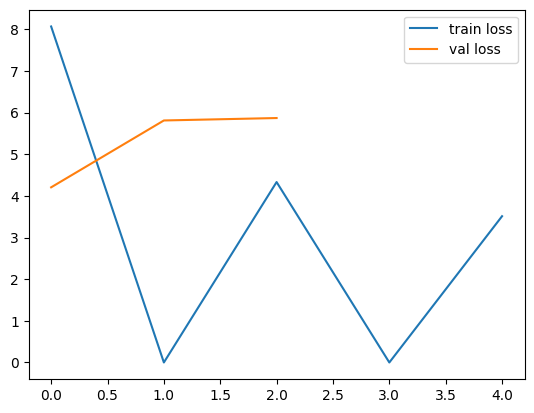

In [9]:
## loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
#plt.savefig('LossVal_loss')

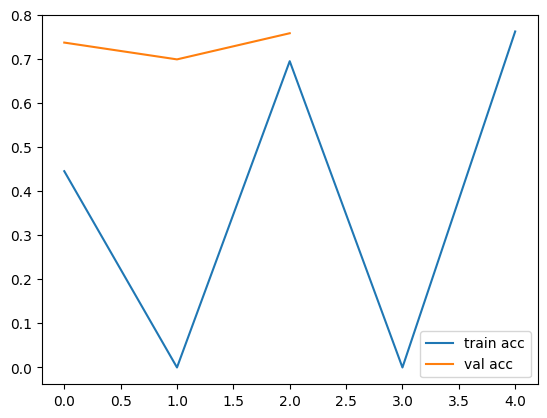

In [10]:
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')  # Corrected key
plt.legend()
plt.show()
#plt.savefig('AccVal_acc')

# **Saved Model**

In [11]:
# model.save('/content/gdrive/MyDrive/Models/VGG16/VGG16_AC_69/VGG16.h5')
model_save_path = '/content/gdrive/MyDrive/PCSD_App/Saved_Model/ResNet50V2.h5'
model.save(model_save_path)
print('Your Model is==> ',os.getcwd())
# Confirm the save path
print(f"Model saved successfully at: {model_save_path}")

Your Model is==>  /content
Model saved successfully at: /content/gdrive/MyDrive/PCSD_App/Saved_Model/ResNet50V2.h5


# **Testing The Model**

In [20]:
# Load the trained model
model_path = model_save_path
# Update with the actual path to your saved model
loaded_model = load_model(model_path)


# Get the class names
class_names = sorted(training_set.class_indices.keys())
print(class_names)


# Specify the path to the test image
test_img_path = '/content/1.jpg'

# Function to preprocess an image
def preprocess_img(img_path):
    img = Image.open(img_path)  # Use PIL to open the image
    img = img.resize((224, 224))  # Resize the image
    img_array = np.array(img)  # Convert PIL image to NumPy array
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalize pixel values
    return img_array

# Function to predict the class of an image
def predict_class(img_path):
    img = preprocess_img(img_path)
    prediction = loaded_model.predict(img)
    predicted_class = class_names[np.argmax(prediction)]
    return predicted_class

# Predict the class for the test image
predicted_class = predict_class(test_img_path)

# Display the test image and predicted class
test_img = cv2.imread(test_img_path)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

plt.imshow(test_img)
plt.title(f'Predicted Class: {predicted_class}')
plt.axis('off')
plt.show()


['1000Rs', '1000Rsback', '100Rs', '100Rsback', '10Rs', '10Rsback', '20Rs', '20Rsback', '5000Rs', '5000Rsback', '500Rs', '500Rsback', '50Rs', '50Rsback', 'others']


AttributeError: 'list' object has no attribute 'read'

# **Saved**

**TFLite Tensorflow Model**

In [ ]:
# Load the Keras model
model = load_model(model_save_path)

# Convert the model to TensorFlow Lite format
converter = lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model
with open('/content/gdrive/MyDrive/PCSD_App/Saved_Model/ResNet50V2.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpuzm4pya6'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 15), dtype=tf.float32, name=None)
Captures:
  139693480424400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139693480495056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139693480503152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139693480501216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139693480501392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139693480503680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139693480507200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139693480507552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139693480508960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139693480505440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13969348050684

**labels.txt**

In [ ]:
# Replace this list with your actual class labels
class_labels = class_names

# Save the class labels to a file
with open("labels.txt", "w") as file:
    for label in class_labels:
        file.write(label + "\n")

# Move the file to the desired directory
import shutil
shutil.move("labels.txt", "/content/gdrive/MyDrive/PCSD_App/Saved_Model/")


'/content/gdrive/MyDrive/PCSD_App/Saved_Model/labels.txt'